<a href="https://colab.research.google.com/github/hiteshchotwani/Sca-key-recovery./blob/main/sca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

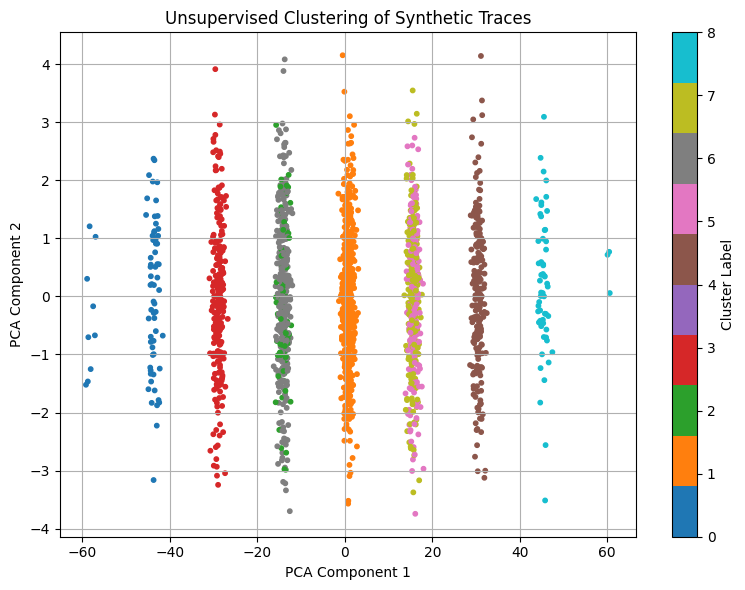


🧠 Adjusted Rand Index (vs HW labels): 0.8672

🔐 Recovered Key Byte (Unsupervised + Heuristics): 2B


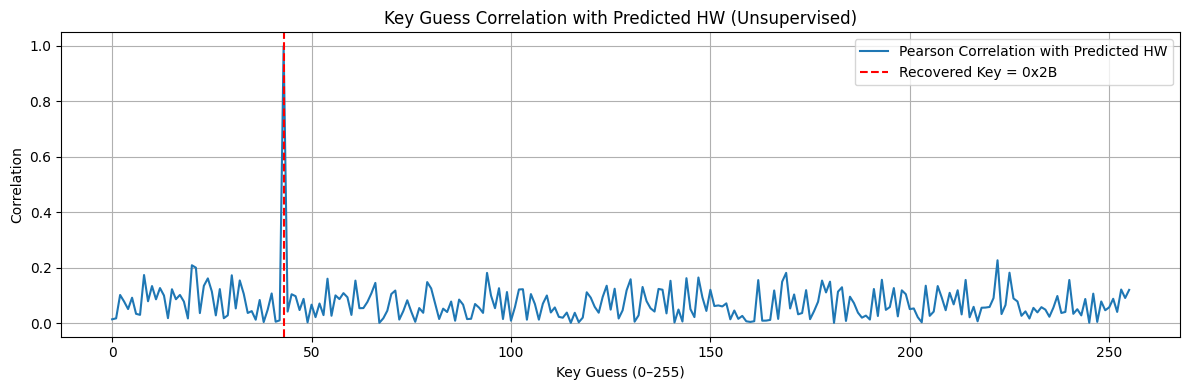

In [1]:
# CNN Side-Channel Analysis using Synthetic Traces (Unsupervised Clustering + Key Recovery)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from scipy.stats import pearsonr
from collections import Counter

# -------------------------------------------
# STEP 1: Generate Synthetic Traces (Same as Before)
# -------------------------------------------

def hamming_weight(n):
    return bin(n).count("1")

np.random.seed(42)
num_traces = 2000
trace_length = 1000
key_byte = 0x2B

plaintexts = np.random.randint(0, 256, size=num_traces)
sbox = [
    0x63,0x7C,0x77,0x7B,0xF2,0x6B,0x6F,0xC5,0x30,0x01,0x67,0x2B,0xFE,0xD7,0xAB,0x76,
    0xCA,0x82,0xC9,0x7D,0xFA,0x59,0x47,0xF0,0xAD,0xD4,0xA2,0xAF,0x9C,0xA4,0x72,0xC0,
    0xB7,0xFD,0x93,0x26,0x36,0x3F,0xF7,0xCC,0x34,0xA5,0xE5,0xF1,0x71,0xD8,0x31,0x15,
    0x04,0xC7,0x23,0xC3,0x18,0x96,0x05,0x9A,0x07,0x12,0x80,0xE2,0xEB,0x27,0xB2,0x75,
    0x09,0x83,0x2C,0x1A,0x1B,0x6E,0x5A,0xA0,0x52,0x3B,0xD6,0xB3,0x29,0xE3,0x2F,0x84,
    0x53,0xD1,0x00,0xED,0x20,0xFC,0xB1,0x5B,0x6A,0xCB,0xBE,0x39,0x4A,0x4C,0x58,0xCF,
    0xD0,0xEF,0xAA,0xFB,0x43,0x4D,0x33,0x85,0x45,0xF9,0x02,0x7F,0x50,0x3C,0x9F,0xA8,
    0x51,0xA3,0x40,0x8F,0x92,0x9D,0x38,0xF5,0xBC,0xB6,0xDA,0x21,0x10,0xFF,0xF3,0xD2,
    0xCD,0x0C,0x13,0xEC,0x5F,0x97,0x44,0x17,0xC4,0xA7,0x7E,0x3D,0x64,0x5D,0x19,0x73,
    0x60,0x81,0x4F,0xDC,0x22,0x2A,0x90,0x88,0x46,0xEE,0xB8,0x14,0xDE,0x5E,0x0B,0xDB,
    0xE0,0x32,0x3A,0x0A,0x49,0x06,0x24,0x5C,0xC2,0xD3,0xAC,0x62,0x91,0x95,0xE4,0x79,
    0xE7,0xC8,0x37,0x6D,0x8D,0xD5,0x4E,0xA9,0x6C,0x56,0xF4,0xEA,0x65,0x7A,0xAE,0x08,
    0xBA,0x78,0x25,0x2E,0x1C,0xA6,0xB4,0xC6,0xE8,0xDD,0x74,0x1F,0x4B,0xBD,0x8B,0x8A,
    0x70,0x3E,0xB5,0x66,0x48,0x03,0xF6,0x0E,0x61,0x35,0x57,0xB9,0x86,0xC1,0x1D,0x9E,
    0xE1,0xF8,0x98,0x11,0x69,0xD9,0x8E,0x94,0x9B,0x1E,0x87,0xE9,0xCE,0x55,0x28,0xDF,
    0x8C,0xA1,0x89,0x0D,0xBF,0xE6,0x42,0x68,0x41,0x99,0x2D,0x0F,0xB0,0x54,0xBB,0x16
]

sbox_outputs = np.array([sbox[p ^ key_byte] for p in plaintexts])
hw_labels = np.array([hamming_weight(v) for v in sbox_outputs])
traces = np.random.normal(loc=hw_labels[:, None] / 8.0, scale=0.2, size=(num_traces, trace_length))

# -------------------------------------------
# STEP 2: Unsupervised Clustering on Traces
# -------------------------------------------

scaler = StandardScaler()
traces_scaled = scaler.fit_transform(traces)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
traces_pca = pca.fit_transform(traces_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=9, random_state=42)
clusters = kmeans.fit_predict(traces_scaled)

# Visualize the clustering results
plt.figure(figsize=(8,6))
plt.scatter(traces_pca[:, 0], traces_pca[:, 1], c=clusters, cmap='tab10', s=10)
plt.title("Unsupervised Clustering of Synthetic Traces")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate clustering performance (optional, only if labels known)
ari_score = adjusted_rand_score(hw_labels, clusters)
print(f"\n🧠 Adjusted Rand Index (vs HW labels): {ari_score:.4f}")

# -------------------------------------------
# STEP 3: Cluster → HW Mapping + Key Recovery
# -------------------------------------------

# Map cluster to most frequent HW label inside it
cluster_to_hw = {}
for i in range(9):
    indices = np.where(clusters == i)[0]
    if len(indices) == 0:
        continue
    hw_vals = hw_labels[indices]
    most_common_hw = Counter(hw_vals).most_common(1)[0][0]
    cluster_to_hw[i] = most_common_hw

predicted_hw = np.array([cluster_to_hw[c] for c in clusters])

# Try all 256 key guesses
correlations = []
for kguess in range(256):
    sbox_outs = np.array([sbox[p ^ kguess] for p in plaintexts])
    hws = np.array([hamming_weight(v) for v in sbox_outs])
    corr, _ = pearsonr(hws, predicted_hw)
    correlations.append(abs(corr))

recovered_key = np.argmax(correlations)
print(f"\n🔐 Recovered Key Byte (Unsupervised + Heuristics): {recovered_key:02X}")
# -------------------------------------------
# STEP 4: Correlation Heatmap for Key Guesses
# -------------------------------------------

plt.figure(figsize=(12, 4))
plt.plot(correlations, label='Pearson Correlation with Predicted HW')
plt.axvline(recovered_key, color='red', linestyle='--', label=f'Recovered Key = 0x{recovered_key:02X}')
plt.title("Key Guess Correlation with Predicted HW (Unsupervised)")
plt.xlabel("Key Guess (0–255)")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

